In [1]:
import sys
import os
import seaborn as sns
import  matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle as pkl
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from IPython.display import display

from Utils.data_preparation import get_feature_set

## Activation Functions in GMLVQ

In [ ]:
fig = plt.figure(figsize=(4,4))
for beta in [1,2,3,4]:  
    x = np.linspace(-1,1,200)
    # y_swish = x/(1+np.exp(-beta*x)) # swish
    y = np.log(1+np.exp(beta*x)) # soft+
    print(np.where(y==np.min(y)))
    plt.plot(x,y,  label='soft+, beta={}'.format(beta))
# y = x/(1+np.exp(-1*x)) # swish
# plt.plot(x, y, label='swish, beta=1')
#y = 1/(1+np.exp(-1*x)) # sigmoid
#plt.plot(x, y, label='sigmoid')
plt.plot(x, x, label='identify')
plt.ylim((-1,3))
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$\Phi$(x)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()
#fig.savefig('/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/GMLVQ/Hyperparameter_Optimization/beta_vs_N_proto/softplus_activation functions.png')


## Plot results from hyperparameter searching

#### SVM

In [ ]:
filepath_base = "/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/Complete_Case/all_pooled/SVM/Multi"
cv_results = pkl.load( open(filepath_base+"/hyperparam_optimization_results.pkl", 'rb') )

metrics = ['ROC-AUC', 'G-mean', 'Sensitivity', 'Specificity']
for this_param_combination in list(cv_results.keys()):
    for metric in metrics:
        for dataset in ['train', 'valid']:
            cv_results[this_param_combination][dataset+'_'+metric+'_mean'] = np.mean(cv_results[this_param_combination][dataset+'_'+metric+'_values'])
            
cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index')
cv_results_df.index.name='params'
cv_results_df = cv_results_df.reset_index()

parameters = []
for i in list(cv_results_df.columns):
    if i.startswith('param_'):
        parameters.append(i)
        print(i, '\t', np.unique(cv_results_df[i]))


In [ ]:
selected_results = cv_results_df.loc[cv_results_df['param_kernel']=='linear']
datasets = ['train', 'valid']
metrics_to_plot = ['ROC-AUC', 'G-mean', 'Sensitivity', 'Specificity']

print_dataset={
    'train': 'Training',
    'valid': 'Validation'
}

n_rows = len(metrics_to_plot)
n_cols = len(datasets)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

for i, metric in enumerate(metrics_to_plot):
    for j, dataset in enumerate(datasets):
        results_table = pd.pivot_table(selected_results, values=dataset+'_'+metric+'_mean', index='param_C', columns='param_gamma')
        results_table.sort_index(ascending=False, inplace=True)
        axes[i,j] = sns.heatmap(results_table, ax=axes[i,j], annot=True, fmt='.3g')
        axes[i,j].set_title(print_dataset[dataset] + ' ' + metric, fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

In [8]:
fig.savefig(filepath_base+'/linear_kernel.png')

## Plot Final Results from Cross Validation

### Plot average results in heatmap

In [ ]:
models = ['Logistic', 'Reg_Logistic', 'SVM', 'GMLVQ', 'GRLVQ']
evaluation_strategy = 'all_pooled' 


metrics_to_report = ['ROC-AUC', 'G-mean', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision']
feature_sets = ['Multi', 'Cog_Demo', 'Image_Demo', 'Demo'] # 'Image_Demo_no_PSMD'
imputation_method = 'Complete_Case' #['Complete_Case', 'KNN_imputer_no_outcome', 'KNN_imputer_with_outcome', 'MF_imputer_no_outcome', 'MF_imputer_with_outcome']

if evaluation_strategy == 'external_harmo_split':
    dataset_names = {
        'train_valid': 'Training',
        'test': 'Internal Validation',
        'harmo': 'HARMO',
        'harmo_high_SVD': 'HARMO High SVD',
        'harmo_low_SVD': 'HARMO Low SVD',
    }
elif evaluation_strategy == 'all_pooled':
    dataset_names = {
        'train_valid': 'Training',
        'test': 'Testing'#'Internal Validation'
    }

full_results = []
for model in models:
    for feature_set in feature_sets:
        this_dict_entry = {
            'Model': model,
            'Feature Set': feature_set
        }

        # Read in full validation results
        input_variables_to_print, FS_name, var_description, cat_feature_indices = get_feature_set(feature_set)
        folderpath = '/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/{}/{}/{}/{}'.format(imputation_method, evaluation_strategy, model, FS_name)
        results_for_this_model_FS = pkl.load( open(folderpath+'/{}_{}.pkl'.format(model, FS_name), 'rb') )['full_validation_results']

        for dataset in list(dataset_names.keys()):
            for metric in metrics_to_report:
                for value in ['mean', 'std']:
                    column_name = '{}_{}_{}'.format(dataset, metric, value)
                    this_dict_entry[column_name] = results_for_this_model_FS[column_name].iloc[0]

                column_name = '{}_{}_values'.format(dataset, metric)
                this_dict_entry[column_name] = results_for_this_model_FS[column_name].iloc[0]

                column_name = '{}_{}_mean_std'.format(dataset, metric)
                this_dict_entry[column_name] = '{:.3f} ({:.3f})'.format(
                    this_dict_entry['{}_{}_mean'.format(dataset, metric)],
                    this_dict_entry['{}_{}_std'.format(dataset, metric)]
                )

        full_results.append(this_dict_entry)
full_results_df = pd.DataFrame(full_results)
full_results_df.head()


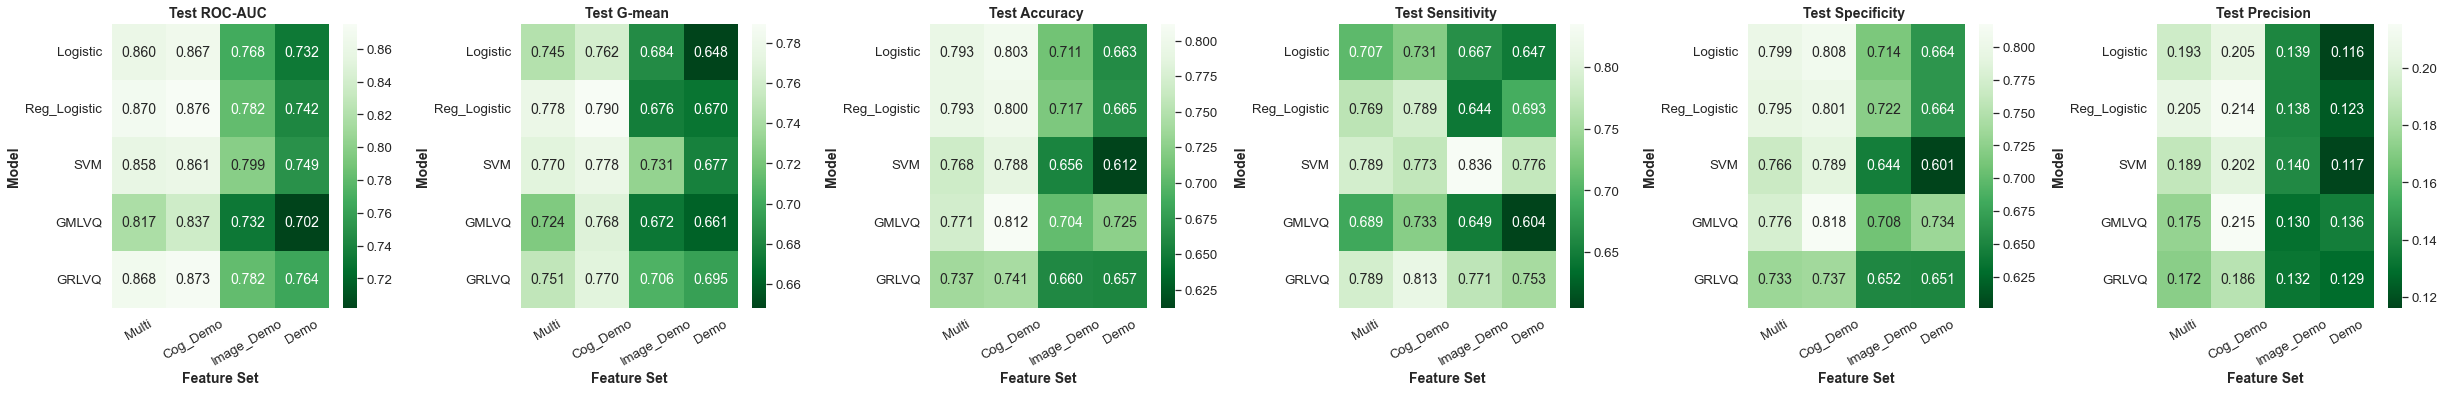

In [3]:
print_dataset={
    'train': 'Training',
    'test': 'Test'
}
sns.set(font_scale=1.2)
dataset_to_report = 'test' # 'MSS2'
col_param = 'Feature Set'
column_order = feature_sets #['Image_Demo', 'Demo']
idx_param = 'Model'
index_order = models
metrics_to_report = ['ROC-AUC', 'G-mean', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision']



metrics_to_plot = metrics_to_report
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(5.7*len(metrics_to_plot), 5.7))
for i, metric in enumerate(metrics_to_plot):
    results_table = pd.pivot_table(full_results_df, values=dataset_to_report+'_'+metric+'_mean', columns=col_param, index=idx_param)
    results_table = results_table.reindex(index_order, axis=0)
    results_table = results_table.reindex(column_order, axis=1)

    axes[i] = sns.heatmap(results_table, ax=axes[i], annot=True, fmt='.3f', cmap='Greens_r', annot_kws={"size": 14}) #sns.cm.rocket) 
    
    axes[i].set_title('{} {} '.format(print_dataset[dataset_to_report],metric), fontsize=14, fontweight='bold')
    #axes[i].set_title('{} {} '.format(dataset_to_report, metric), fontsize=14, fontweight='bold')
    
    axes[i].set_xlabel(col_param, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(idx_param, fontsize=14, fontweight='bold')

    tl = axes[i].get_yticklabels()
    axes[i].set_yticklabels(tl, rotation=0)

    tl = axes[i].get_xticklabels()
    axes[i].set_xticklabels(tl, rotation=30)

plt.tight_layout()
plt.show()

In [4]:
fig.savefig('/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/Complete_Case/all_pooled/test_results.pdf')

### Test for significant differences between models

In [ ]:
from scipy.stats import ttest_rel

model_1 = 'Logistic'
model_2 = 'Reg_Logistic'
print(model_1, model_2)
for dataset in ['test']:#['test']:
    for metric in metrics_to_report:
        for feature_set in feature_sets:
            row_for_model_1 = full_results_df.loc[(full_results_df['Model']==model_1) & (full_results_df['Feature Set']==feature_set)]
            
            row_for_model_2 = full_results_df.loc[(full_results_df['Model']==model_2) & (full_results_df['Feature Set']==feature_set)]

            column_name = '{}_{}_values'.format(dataset, metric)
            values_1 = row_for_model_1[column_name].iloc[0]
            values_2 = row_for_model_2[column_name].iloc[0]
            assert len(values_1) == len(values_2) == 5
            
            statistic, pval = ttest_rel(values_1, values_2)
            if pval <0.05: # statistic<0 indicates values_1 less than values_2
                if statistic<0:
                    print('{}\t{}\t{}\t pval:{}\t {} larger'.format(dataset, metric, feature_set, pval, model_2))
                else:
                    print('{}\t{}\t{}\t pval:{}\t {} larger'.format(dataset, metric, feature_set, pval, model_1))
                print(np.mean(values_1), np.mean(values_2))
            

### Plot both training and testing results

In [ ]:
models = ['Logistic', 'Reg_Logistic', 'SVM', 'GMLVQ', 'GRLVQ']
evaluation_strategy = 'all_pooled' 


metrics_to_report = ['ROC-AUC', 'G-mean', 'Sensitivity', 'Specificity', 'Precision', 'Accuracy']
feature_sets = ['Multi', 'Cog_Demo', 'Image_Demo', 'Demo']
imputation_methods = ['Complete_Case']


sns_pallete = {
    'Logistic': sns.color_palette()[0],
    'Reg_Logistic': sns.color_palette()[2],
    'GRLVQ': sns.color_palette()[1],
    'GMLVQ': sns.color_palette()[3],
    'SVM': sns.color_palette()[4]}

if evaluation_strategy == 'external_harmo_split':
    dataset_names = {
        'train_valid': 'Training',
        'test': 'Internal Validation',
        'harmo': 'HARMO',
        'harmo_high_SVD': 'HARMO High SVD',
        'harmo_low_SVD': 'HARMO Low SVD',
    }
elif evaluation_strategy == 'all_pooled':
    dataset_names = {
        'train_valid': 'Training',
        'test': 'Test'#'Internal Validation'
    }

model_FS_dataset_metric_imputation_df_lst = []
for imputation_method in imputation_methods:
    model_FS_dataset_metric_df_lst = []
    for model in models:
        FS_dataset_metric_df_lst = []
        for FS_idx, this_feature_set in enumerate(feature_sets):
            # Read in full validation results
            input_variables_to_print, FS_name, var_description, cat_feature_indices = get_feature_set(this_feature_set)
            folderpath = '/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/{}/{}/{}/{}'.format(imputation_method, evaluation_strategy, model, FS_name)
            this_results_dict = pkl.load( open(folderpath+'/{}_{}.pkl'.format(model, FS_name), 'rb') )
            this_validation_results = this_results_dict['full_validation_results']

            dataset_metric_df_lst = []
            for dataset in list(dataset_names.keys()):
                dataset_metric_df = {}
                for metric in metrics_to_report:
                    dataset_metric_df[metric] = this_validation_results[dataset+'_'+metric+'_values'].iloc[0]
                    
                dataset_metric_df = pd.DataFrame.from_dict(dataset_metric_df)
                dataset_metric_df['Dataset'] = dataset_names[dataset]
                dataset_metric_df_lst.append(dataset_metric_df)
            
            FS_dataset_metric_df = pd.concat(dataset_metric_df_lst)
            FS_dataset_metric_df['Feature Set'] = this_feature_set
            FS_dataset_metric_df_lst.append(FS_dataset_metric_df)
        model_FS_dataset_metric_df = pd.concat(FS_dataset_metric_df_lst)
        model_FS_dataset_metric_df['Model'] = model
        model_FS_dataset_metric_df_lst.append(model_FS_dataset_metric_df)
    model_FS_dataset_metric_imputation_df = pd.concat(model_FS_dataset_metric_df_lst)
    model_FS_dataset_metric_imputation_df['Imputation'] = imputation_method
    model_FS_dataset_metric_imputation_df_lst.append(model_FS_dataset_metric_imputation_df)

complete_df = pd.concat(model_FS_dataset_metric_imputation_df_lst)
print(complete_df.shape)
complete_df.loc[(complete_df['Dataset']=='Test') & (complete_df['Feature Set']=='Multi') & (complete_df['Model']=='SVM')]

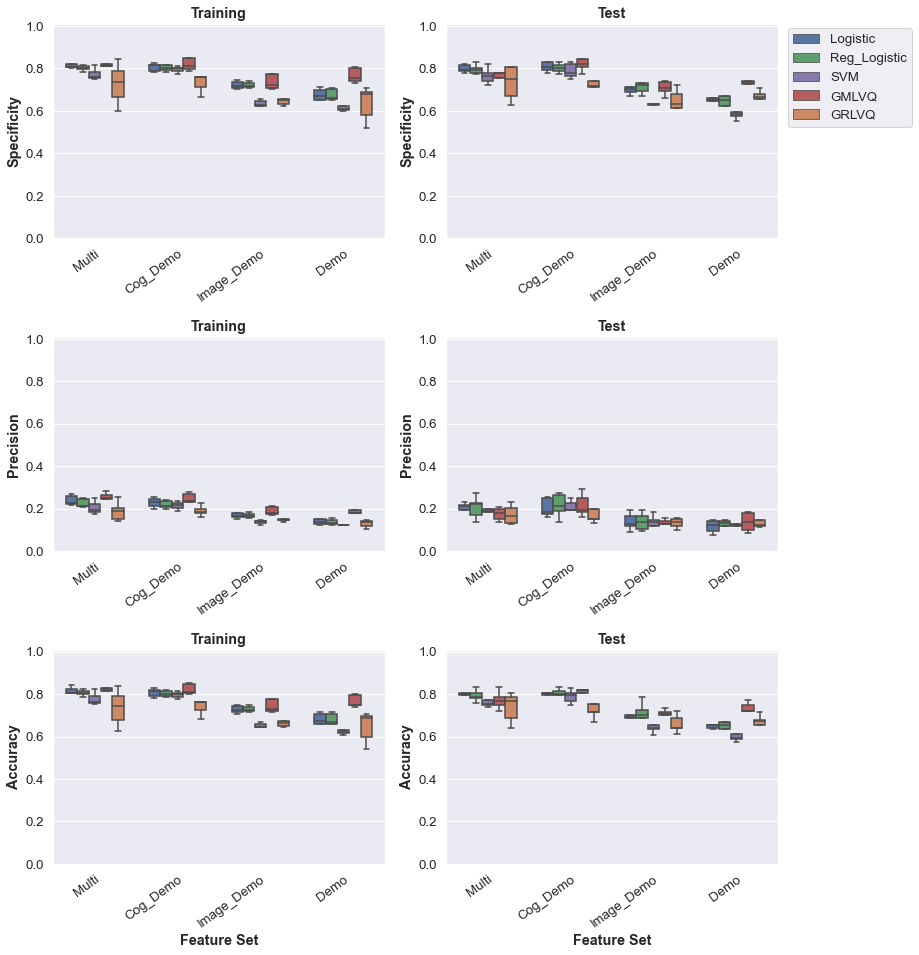

In [10]:
sns.set(font_scale = 1.2)
metrics_to_plot = metrics_to_report[3:]
datasets = list(dataset_names.keys())

num_rows = len(metrics_to_plot)
num_cols = len(datasets)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6.5*num_cols,4.5*num_rows), sharex=False)
for i, metric in enumerate(metrics_to_plot):
    for j, dataset in enumerate(datasets):
        results_for_this_dataset = complete_df.loc[complete_df['Dataset']==dataset_names[dataset]]
        sns.boxplot(x="Feature Set", y=metric, hue="Model", hue_order=models, data=results_for_this_dataset, ax=axes[i,j], showfliers=False, width=0.7, palette=sns_pallete)# fliersize=2
        axes[i,j].set_title(dataset_names[dataset], fontweight='bold')

        if i != num_rows-1:
            axes[i,j].set_xlabel('')
        else:
            axes[i,j].set_xlabel('Feature Set', fontweight='bold')
        axes[i,j].set_ylabel(metric, fontweight='bold')
        
        axes[i,j].get_legend().remove()

        if metric == 'ROC-AUC':
            axes[i,j].set_ylim([0.5,1.01])
        else:
            axes[i,j].set_ylim([0.0,1.01])

        plt.setp(axes[i,j].get_xticklabels(), rotation=36, ha="right",rotation_mode="anchor")

axes[0,len(datasets)-1].legend(bbox_to_anchor=(1.01, 1.01))
#fig.suptitle(np.unique(complete_df['Imputation']))
plt.tight_layout()
plt.show()

In [11]:
fig.savefig('/Users/lirui/Downloads/Cohort_Dementia_Prediction/Classification/Nested_CV_Results/{}/{}/Classification_CV_Boxplots 2.pdf'.format(imputation_methods[0], evaluation_strategy), bbox_inches='tight')

In [ ]:
metric = 'Precision'
dataset = 'Testing'
summary_results = {}
for feature_set in list(np.unique(complete_df['Feature Set'])):
    summary_results[feature_set] = {}
    for model in ['Logistic', 'Reg_Logistic', 'GMLVQ', 'GRLVQ', 'SVM']:
        selected_df = complete_df.loc[(complete_df['Dataset']==dataset) & (complete_df['Feature Set']==feature_set) & (complete_df['Model']==model)]
        summary_results[feature_set][model] ={
            'Mean': np.round(np.mean(selected_df[metric]),3),
            'SD': np.round(np.std(selected_df[metric]),3)
        }
summary_results_df = pd.DataFrame.from_dict({(i,j): summary_results[i][j] 
                           for i in summary_results.keys() 
                           for j in summary_results[i].keys()},
                       orient='index')
print(metric, dataset)
display(summary_results_df)